# k-meansクラスタリング (k-means Clustering) の理解

## 目次
1. k-meansクラスタリングとは
2. 基本原理：アルゴリズムの流れ
3. 例1: 基本的な2次元データのクラスタリング
4. 例2: クラスタ数の選択（エルボー法）
5. 例3: k-means++による初期化の改善
6. 例4: 異なるデータ分布での比較
7. 収束性とパフォーマンスの分析

In [2]:
# 必要なライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

# 日本語フォントの設定
rcParams['font.sans-serif'] = ['DejaVu Sans']
rcParams['axes.unicode_minus'] = False

# 乱数シードの設定（再現性のため）
np.random.seed(42)

print("ライブラリのインポート完了")

ライブラリのインポート完了


## 1. k-meansクラスタリングとは

**k-meansクラスタリング**は、データをk個のグループ（クラスタ）に分割する教師なし学習の代表的な手法です。

### 主な特徴
- 📊 **分割型クラスタリング**: データをk個の排他的グループに分割
- 🎯 **重心ベース**: 各クラスタの中心（セントロイド）を最適化
- ⚡ **高速**: 大規模データにも適用可能
- 🔄 **反復的**: EMアルゴリズムに似た反復改善

### 目的関数
k-meansは以下のクラスタ内平方和（WCSS: Within-Cluster Sum of Squares）を最小化します：

$$J = \sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2$$

ここで、$C_i$はクラスタi、$\mu_i$はクラスタiの重心です。

## 2. 基本原理：アルゴリズムの流れ

k-meansアルゴリズムは以下のステップを繰り返します：

1. **初期化**: k個の重心をランダムに選択
2. **割り当てステップ**: 各データポイントを最も近い重心のクラスタに割り当て
3. **更新ステップ**: 各クラスタの重心を、そのクラスタに属するデータポイントの平均として再計算
4. 収束するまで2-3を繰り返す

### アルゴリズムの可視化

k-meansアルゴリズムの各ステップの可視化
収束しました（Step 3）


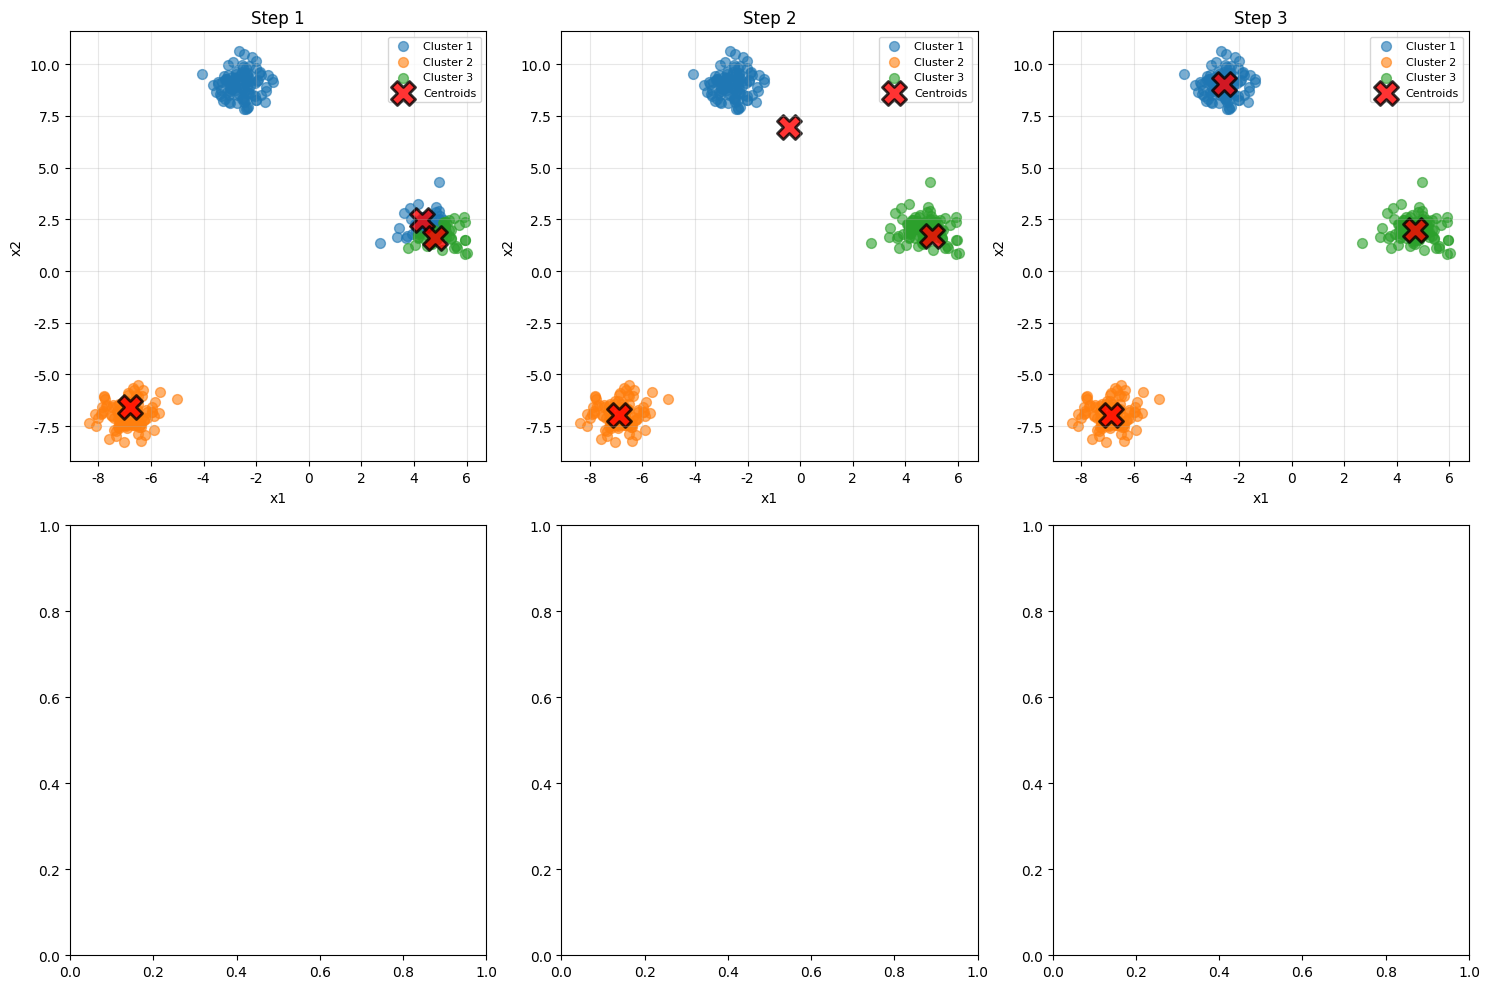

In [3]:
def visualize_kmeans_steps(X, n_clusters=3, n_steps=10):
    """
    k-meansアルゴリズムの各ステップを可視化
    """
    # 初期重心をランダムに選択
    np.random.seed(42)
    initial_centers = X[np.random.choice(X.shape[0], n_clusters, replace=False)]
    
    centers = initial_centers.copy()
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for step in range(min(6, n_steps)):
        ax = axes[step]
        
        # 割り当てステップ：各点を最も近い重心に割り当て
        distances = cdist(X, centers)
        labels = np.argmin(distances, axis=1)
        
        # プロット
        for i in range(n_clusters):
            cluster_points = X[labels == i]
            ax.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                      s=50, alpha=0.6, label=f'Cluster {i+1}')
        
        # 重心をプロット
        ax.scatter(centers[:, 0], centers[:, 1], 
                  c='red', s=300, alpha=0.8, marker='X', 
                  edgecolors='black', linewidths=2, label='Centroids')
        
        ax.set_title(f'Step {step + 1}')
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)
        
        # 更新ステップ：新しい重心を計算
        new_centers = np.array([X[labels == i].mean(axis=0) 
                               for i in range(n_clusters)])
        
        # 収束チェック
        if np.allclose(centers, new_centers):
            print(f"収束しました（Step {step + 1}）")
            break
        
        centers = new_centers
    
    plt.tight_layout()
    plt.show()

# サンプルデータの生成
X_demo, y_demo = make_blobs(n_samples=300, centers=3, n_features=2, 
                            cluster_std=0.6, random_state=42)

print("k-meansアルゴリズムの各ステップの可視化")
visualize_kmeans_steps(X_demo, n_clusters=3)

## 3. 例1: 基本的な2次元データのクラスタリング

まず、明確に分離された3つのクラスタを持つデータでk-meansの動作を確認します。

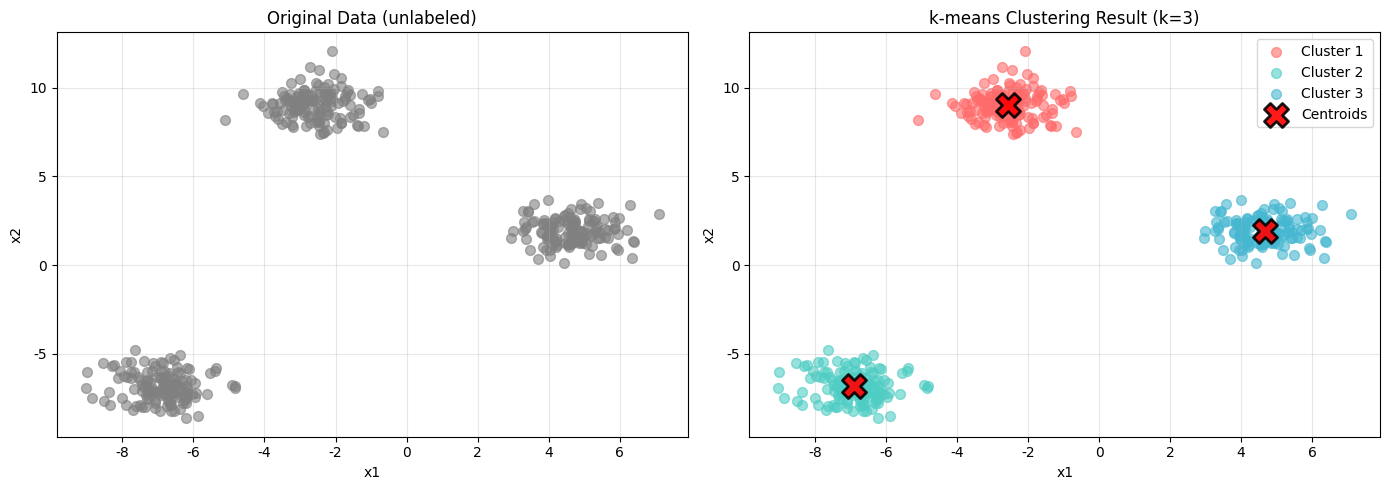

クラスタ内平方和 (Inertia): 492.50
シルエット係数: 0.877
反復回数: 2


In [4]:
def basic_kmeans_example():
    """
    基本的なk-meansクラスタリングの例
    """
    # データ生成
    X, y_true = make_blobs(n_samples=400, centers=3, n_features=2,
                          cluster_std=0.8, random_state=42)
    
    # k-meansクラスタリング
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    y_pred = kmeans.fit_predict(X)
    centers = kmeans.cluster_centers_
    
    # プロット
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # 元のデータ
    ax1.scatter(X[:, 0], X[:, 1], c='gray', s=50, alpha=0.6)
    ax1.set_title('Original Data (unlabeled)')
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    ax1.grid(True, alpha=0.3)
    
    # クラスタリング結果
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    for i in range(3):
        cluster_points = X[y_pred == i]
        ax2.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                   c=colors[i], s=50, alpha=0.6, label=f'Cluster {i+1}')
    
    ax2.scatter(centers[:, 0], centers[:, 1], c='red', s=300, 
               alpha=0.9, marker='X', edgecolors='black', linewidths=2,
               label='Centroids')
    ax2.set_title('k-means Clustering Result (k=3)')
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 評価指標の計算
    inertia = kmeans.inertia_
    silhouette = silhouette_score(X, y_pred)
    
    print(f"クラスタ内平方和 (Inertia): {inertia:.2f}")
    print(f"シルエット係数: {silhouette:.3f}")
    print(f"反復回数: {kmeans.n_iter_}")

basic_kmeans_example()

## 4. 例2: クラスタ数の選択（エルボー法）

適切なクラスタ数kを選択することは重要です。**エルボー法**は、異なるk値に対するクラスタ内平方和（WCSS）をプロットし、
「肘」のような屈曲点を見つける方法です。

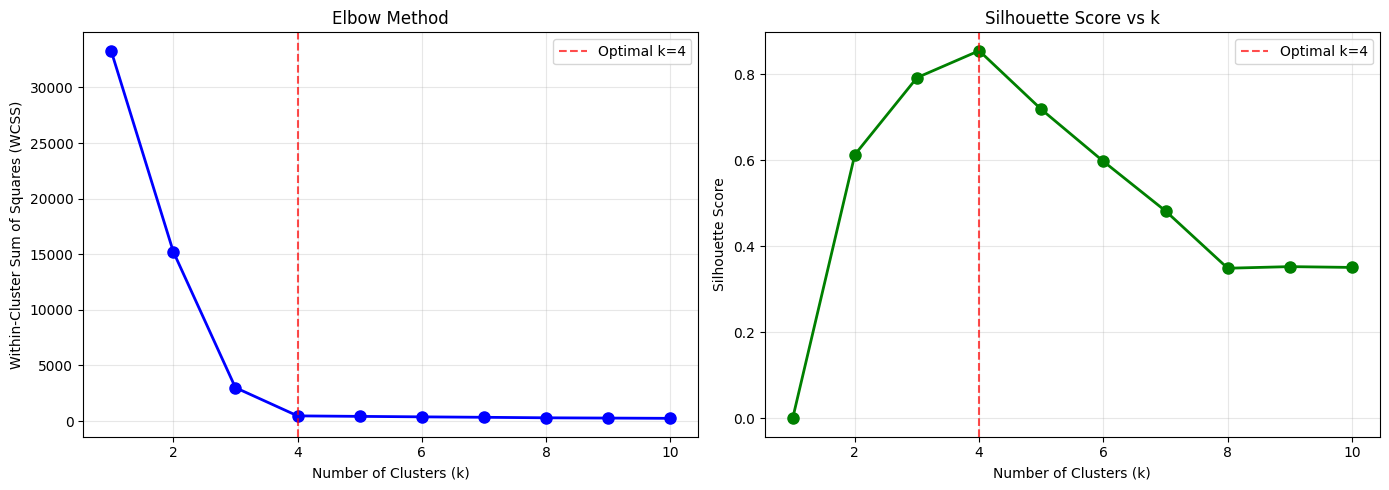

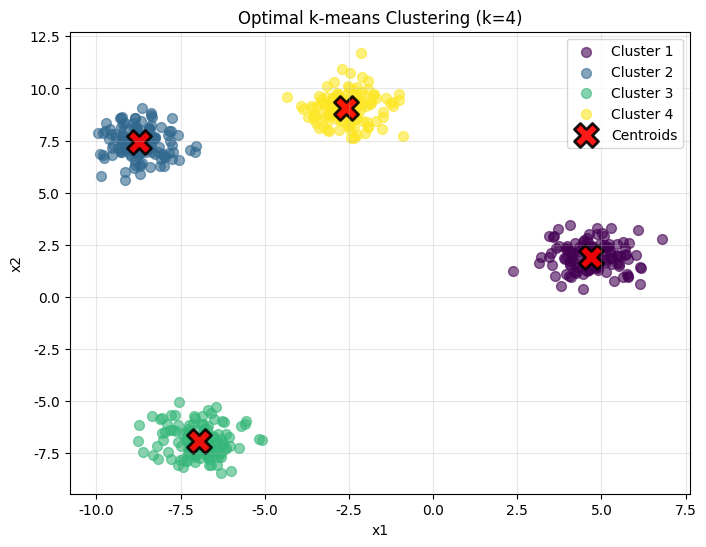


最適なクラスタ数: k=4
WCSS: 464.96
シルエット係数: 0.855


In [5]:
def elbow_method_analysis():
    """
    エルボー法によるクラスタ数の選択
    """
    # データ生成
    X, _ = make_blobs(n_samples=500, centers=4, n_features=2,
                     cluster_std=0.7, random_state=42)
    
    # 異なるk値でk-meansを実行
    K_range = range(1, 11)
    inertias = []
    silhouette_scores = []
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        
        # シルエット係数（k=1では計算不可）
        if k > 1:
            silhouette_scores.append(silhouette_score(X, kmeans.labels_))
        else:
            silhouette_scores.append(0)
    
    # プロット
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # エルボープロット
    ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Within-Cluster Sum of Squares (WCSS)')
    ax1.set_title('Elbow Method')
    ax1.axvline(x=4, color='red', linestyle='--', alpha=0.7, label='Optimal k=4')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # シルエット係数プロット
    ax2.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Score vs k')
    ax2.axvline(x=4, color='red', linestyle='--', alpha=0.7, label='Optimal k=4')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 最適なk値での結果を表示
    optimal_k = 4
    kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    y_pred = kmeans_optimal.fit_predict(X)
    
    plt.figure(figsize=(8, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, optimal_k))
    
    for i in range(optimal_k):
        cluster_points = X[y_pred == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                   c=[colors[i]], s=50, alpha=0.6, label=f'Cluster {i+1}')
    
    centers = kmeans_optimal.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=300,
               alpha=0.9, marker='X', edgecolors='black', linewidths=2,
               label='Centroids')
    
    plt.title(f'Optimal k-means Clustering (k={optimal_k})')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"\n最適なクラスタ数: k={optimal_k}")
    print(f"WCSS: {kmeans_optimal.inertia_:.2f}")
    print(f"シルエット係数: {silhouette_score(X, y_pred):.3f}")

elbow_method_analysis()

## 5. 例3: k-means++による初期化の改善

標準的なk-meansはランダムに初期重心を選択するため、局所最適解に陥る可能性があります。
**k-means++**は、より良い初期重心を選択することで、この問題を改善します。

/tmp/ipykernel_50207/2865785269.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(data_to_plot, labels=['Random', 'k-means++'])


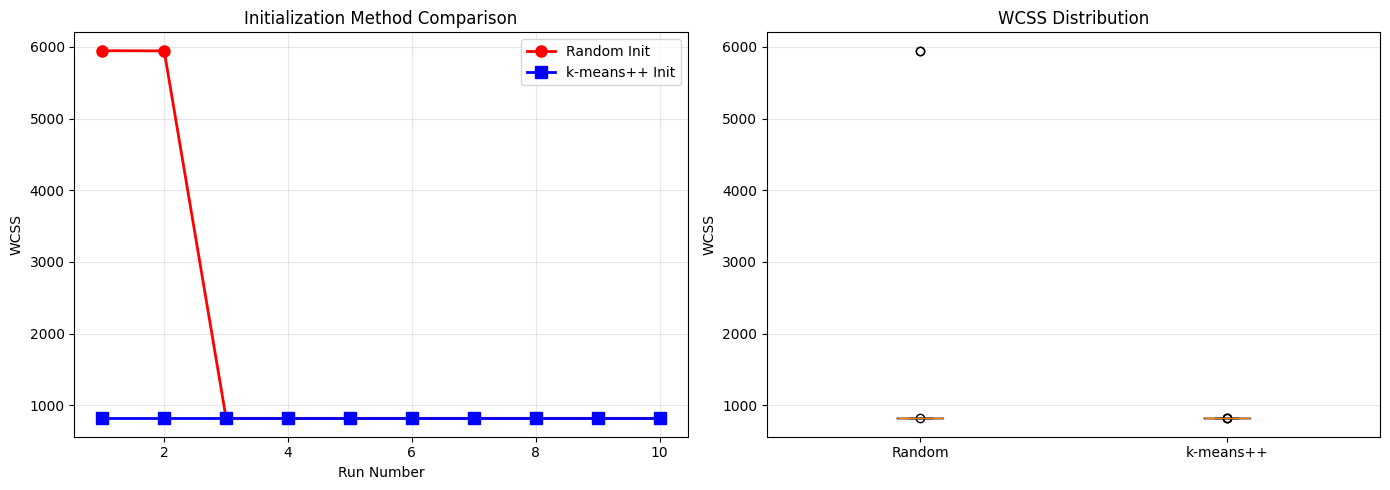

ランダム初期化:
  平均WCSS: 1842.28
  標準偏差: 2052.01
  最小値: 816.28
  最大値: 5947.50

k-means++初期化:
  平均WCSS: 816.28
  標準偏差: 0.00
  最小値: 816.28
  最大値: 816.28

k-means++による改善: 55.69%


In [6]:
def compare_initialization_methods():
    """
    ランダム初期化とk-means++の比較
    """
    # データ生成（やや複雑な分布）
    X, _ = make_blobs(n_samples=300, centers=3, n_features=2,
                     cluster_std=1.2, random_state=42)
    
    # 複数回実行して結果を比較
    n_runs = 10
    random_inertias = []
    kmeanspp_inertias = []
    
    for i in range(n_runs):
        # ランダム初期化
        kmeans_random = KMeans(n_clusters=3, init='random', 
                              random_state=i, n_init=1)
        kmeans_random.fit(X)
        random_inertias.append(kmeans_random.inertia_)
        
        # k-means++初期化
        kmeans_pp = KMeans(n_clusters=3, init='k-means++',
                          random_state=i, n_init=1)
        kmeans_pp.fit(X)
        kmeanspp_inertias.append(kmeans_pp.inertia_)
    
    # 結果の可視化
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # WCSSの比較
    ax1.plot(range(1, n_runs+1), random_inertias, 'ro-', 
            label='Random Init', linewidth=2, markersize=8)
    ax1.plot(range(1, n_runs+1), kmeanspp_inertias, 'bs-',
            label='k-means++ Init', linewidth=2, markersize=8)
    ax1.set_xlabel('Run Number')
    ax1.set_ylabel('WCSS')
    ax1.set_title('Initialization Method Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # ボックスプロット
    data_to_plot = [random_inertias, kmeanspp_inertias]
    ax2.boxplot(data_to_plot, labels=['Random', 'k-means++'])
    ax2.set_ylabel('WCSS')
    ax2.set_title('WCSS Distribution')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # 統計情報
    print(f"ランダム初期化:")
    print(f"  平均WCSS: {np.mean(random_inertias):.2f}")
    print(f"  標準偏差: {np.std(random_inertias):.2f}")
    print(f"  最小値: {np.min(random_inertias):.2f}")
    print(f"  最大値: {np.max(random_inertias):.2f}")
    
    print(f"\nk-means++初期化:")
    print(f"  平均WCSS: {np.mean(kmeanspp_inertias):.2f}")
    print(f"  標準偏差: {np.std(kmeanspp_inertias):.2f}")
    print(f"  最小値: {np.min(kmeanspp_inertias):.2f}")
    print(f"  最大値: {np.max(kmeanspp_inertias):.2f}")
    
    improvement = (np.mean(random_inertias) - np.mean(kmeanspp_inertias)) / np.mean(random_inertias) * 100
    print(f"\nk-means++による改善: {improvement:.2f}%")

compare_initialization_methods()

## 6. 例4: 異なるデータ分布での比較

k-meansは球状のクラスタに対して最も効果的です。非球状の分布ではどうなるか見てみましょう。

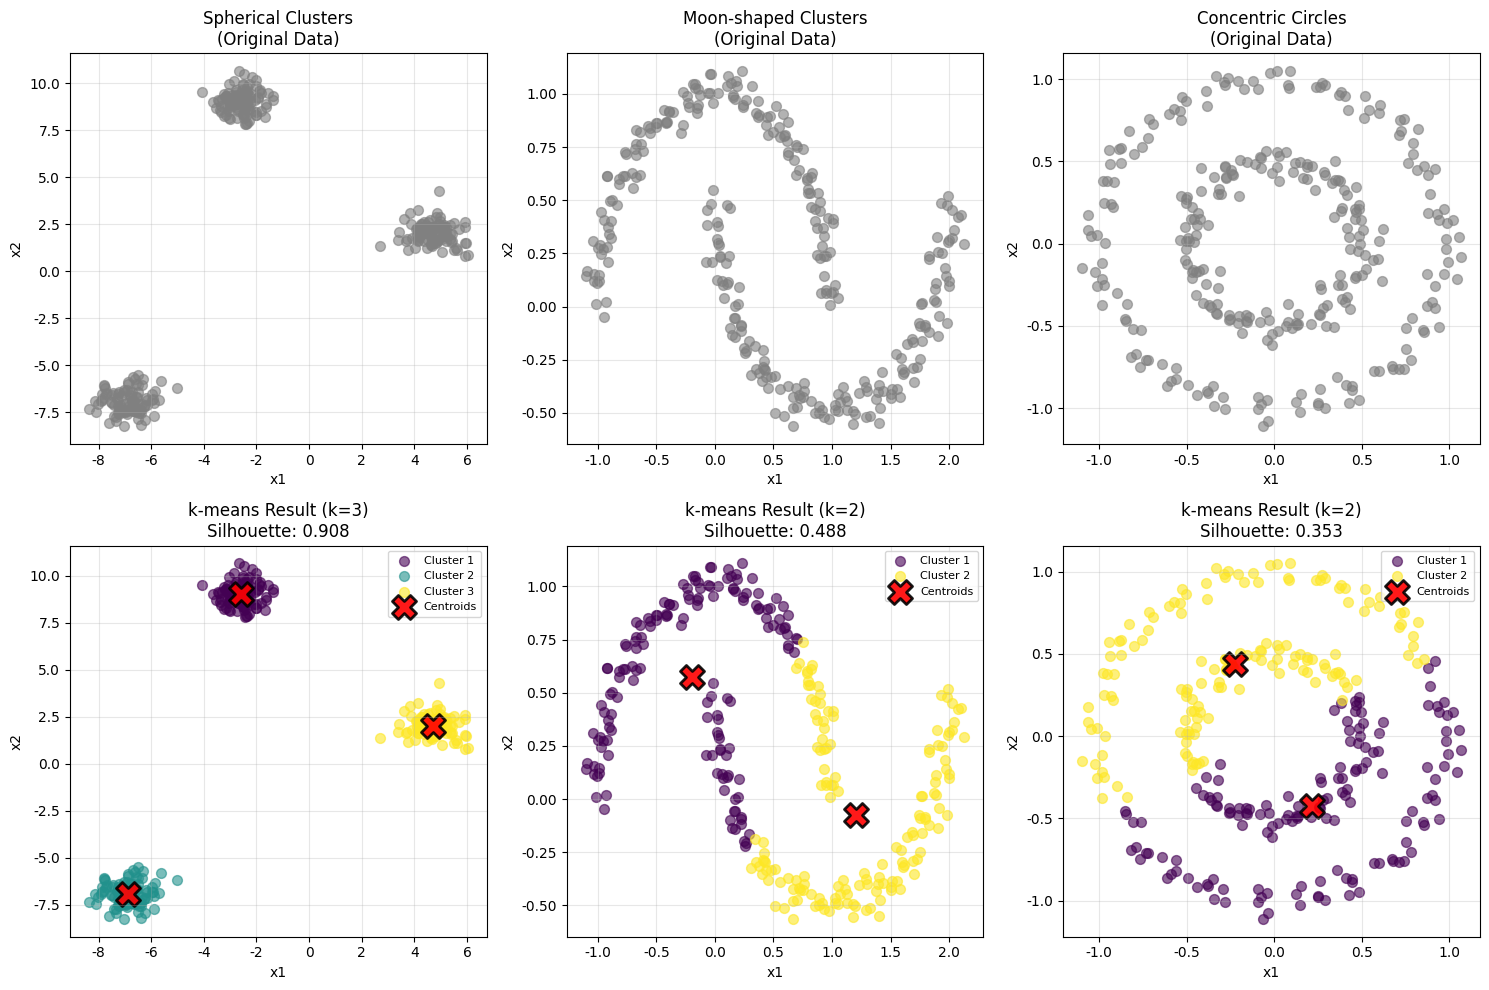

k-meansの性能評価:

1. 球状クラスタ: ✓ 非常に良好
   - k-meansの仮定（球状、等分散）に適合

2. 月型クラスタ: ✗ 不良
   - 非凸形状には適さない
   - 密度ベースのクラスタリング（DBSCAN等）が推奨

3. 同心円: ✗ 不良
   - ユークリッド距離ベースの限界
   - スペクトラルクラスタリング等が推奨


In [7]:
def compare_different_distributions():
    """
    異なるデータ分布でのk-meansの性能比較
    """
    # 3種類のデータセットを生成
    n_samples = 300
    
    # 1. 球状クラスタ（k-meansに最適）
    X_blobs, _ = make_blobs(n_samples=n_samples, centers=3, 
                           cluster_std=0.6, random_state=42)
    
    # 2. 月型（非凸形状）
    X_moons, _ = make_moons(n_samples=n_samples, noise=0.05, random_state=42)
    
    # 3. 同心円
    X_circles, _ = make_circles(n_samples=n_samples, factor=0.5, 
                               noise=0.05, random_state=42)
    
    datasets = [
        (X_blobs, 3, 'Spherical Clusters'),
        (X_moons, 2, 'Moon-shaped Clusters'),
        (X_circles, 2, 'Concentric Circles')
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for i, (X, n_clusters, title) in enumerate(datasets):
        # 元のデータ
        axes[0, i].scatter(X[:, 0], X[:, 1], c='gray', s=50, alpha=0.6)
        axes[0, i].set_title(f'{title}\n(Original Data)')
        axes[0, i].set_xlabel('x1')
        axes[0, i].set_ylabel('x2')
        axes[0, i].grid(True, alpha=0.3)
        
        # k-meansクラスタリング
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        y_pred = kmeans.fit_predict(X)
        centers = kmeans.cluster_centers_
        
        # クラスタリング結果
        colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))
        for j in range(n_clusters):
            cluster_points = X[y_pred == j]
            axes[1, i].scatter(cluster_points[:, 0], cluster_points[:, 1],
                             c=[colors[j]], s=50, alpha=0.6, 
                             label=f'Cluster {j+1}')
        
        axes[1, i].scatter(centers[:, 0], centers[:, 1], c='red', s=300,
                         alpha=0.9, marker='X', edgecolors='black', 
                         linewidths=2, label='Centroids')
        
        # シルエット係数を計算
        silhouette = silhouette_score(X, y_pred)
        
        axes[1, i].set_title(f'k-means Result (k={n_clusters})\nSilhouette: {silhouette:.3f}')
        axes[1, i].set_xlabel('x1')
        axes[1, i].set_ylabel('x2')
        axes[1, i].legend(loc='best', fontsize=8)
        axes[1, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("k-meansの性能評価:")
    print("\n1. 球状クラスタ: ✓ 非常に良好")
    print("   - k-meansの仮定（球状、等分散）に適合")
    print("\n2. 月型クラスタ: ✗ 不良")
    print("   - 非凸形状には適さない")
    print("   - 密度ベースのクラスタリング（DBSCAN等）が推奨")
    print("\n3. 同心円: ✗ 不良")
    print("   - ユークリッド距離ベースの限界")
    print("   - スペクトラルクラスタリング等が推奨")

compare_different_distributions()

## 7. 収束性とパフォーマンスの分析

k-meansの収束速度とデータサイズに対するスケーラビリティを分析します。

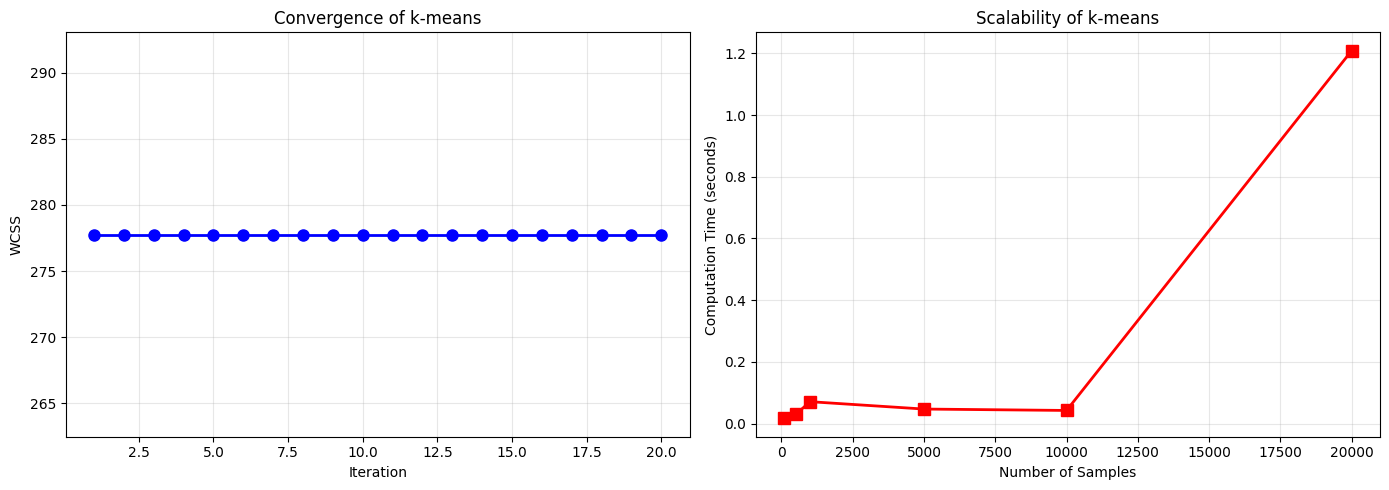

収束性の分析:
  初期WCSS: 277.76
  最終WCSS: 277.76
  改善率: 0.00%
  収束までの反復回数: 1

スケーラビリティの分析:
     100 samples: 0.0170 seconds
     500 samples: 0.0294 seconds
    1000 samples: 0.0709 seconds
    5000 samples: 0.0470 seconds
   10000 samples: 0.0425 seconds
   20000 samples: 1.2085 seconds


In [8]:
def analyze_convergence_and_performance():
    """
    収束性とパフォーマンスの分析
    """
    # 1. 収束過程の可視化
    X, _ = make_blobs(n_samples=300, centers=3, n_features=2,
                     cluster_std=0.7, random_state=42)
    
    # 各反復でのWCSSを記録
    max_iter = 20
    wcss_history = []
    
    for i in range(1, max_iter + 1):
        kmeans = KMeans(n_clusters=3, max_iter=i, random_state=42, n_init=1)
        kmeans.fit(X)
        wcss_history.append(kmeans.inertia_)
    
    # 2. データサイズとの関係
    sample_sizes = [100, 500, 1000, 5000, 10000, 20000]
    computation_times = []
    
    import time
    
    for n_samples in sample_sizes:
        X_large, _ = make_blobs(n_samples=n_samples, centers=3, 
                               n_features=2, random_state=42)
        
        start_time = time.time()
        kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
        kmeans.fit(X_large)
        end_time = time.time()
        
        computation_times.append(end_time - start_time)
    
    # プロット
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # 収束過程
    ax1.plot(range(1, max_iter + 1), wcss_history, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('WCSS')
    ax1.set_title('Convergence of k-means')
    ax1.grid(True, alpha=0.3)
    
    # 計算時間のスケーラビリティ
    ax2.plot(sample_sizes, computation_times, 'rs-', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Samples')
    ax2.set_ylabel('Computation Time (seconds)')
    ax2.set_title('Scalability of k-means')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 統計情報
    print("収束性の分析:")
    print(f"  初期WCSS: {wcss_history[0]:.2f}")
    print(f"  最終WCSS: {wcss_history[-1]:.2f}")
    print(f"  改善率: {(1 - wcss_history[-1]/wcss_history[0])*100:.2f}%")
    
    # 収束までの反復回数を推定（WCSSの変化が1%未満）
    for i in range(1, len(wcss_history)):
        change = abs(wcss_history[i] - wcss_history[i-1]) / wcss_history[i-1]
        if change < 0.01:
            print(f"  収束までの反復回数: {i}")
            break
    
    print("\nスケーラビリティの分析:")
    for size, time_val in zip(sample_sizes, computation_times):
        print(f"  {size:6d} samples: {time_val:.4f} seconds")

analyze_convergence_and_performance()

**参考文献**
- MacQueen, J. (1967). Some methods for classification and analysis of multivariate observations.
- Arthur, D., & Vassilvitskii, S. (2007). k-means++: The advantages of careful seeding.
- Jain, A. K. (2010). Data clustering: 50 years beyond K-means.
- scikit-learn documentation: https://scikit-learn.org/stable/modules/clustering.html